In [1]:
%pip install -q dagshub mlflow

Note: you may need to restart the kernel to use updated packages.


# Import/setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import gc
import mlflow
import mlflow.sklearn
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow'
os.environ['MLFLOW_TRACKING_USERNAME'] = 'g-kitiashvili'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '1c2227158cc19daf66bb3b241116a8e8c5f1cd20'

model_name = "RandomForest"
mlflow.set_experiment(f"{model_name}_Training")


<Experiment: artifact_location='mlflow-artifacts:/60102701a51d46e9a1481ddb1dac1935', creation_time=1745338290301, experiment_id='2', last_update_time=1745338290301, lifecycle_stage='active', name='RandomForest_Training', tags={}>

 # Data Loading and Preparation


In [3]:
print("Loading data...")

train_transaction = pd.read_csv('./data/train_transaction.csv')
test_transaction = pd.read_csv('./data/test_transaction.csv')

train_identity = pd.read_csv('./data/train_identity.csv')
test_identity = pd.read_csv('./data/test_identity.csv')

print(f"Train transaction shape: {train_transaction.shape}")
print(f"Test transaction shape: {test_transaction.shape}")
print(f"Train identity shape: {train_identity.shape}")
print(f"Test identity shape: {test_identity.shape}")

with mlflow.start_run(run_name=f"{model_name}_Initial_Preparation") as run:
    print("Merging data...")
    
    train = train_transaction.merge(train_identity, on='TransactionID', how='left')
    test = test_transaction.merge(test_identity, on='TransactionID', how='left')
    
    mlflow.log_param("train_original_shape", train.shape)
    mlflow.log_param("test_original_shape", test.shape)
    
    del train_transaction, train_identity
    gc.collect()
    
    target = 'isFraud'
    y_train = train[target].copy()
    train_transaction_id = train['TransactionID'].copy()
    test_transaction_id = test['TransactionID'].copy()
    
    fraud_ratio = y_train.mean()
    mlflow.log_param("fraud_ratio", fraud_ratio)
    print(f"Fraud ratio: {fraud_ratio:.4f}")
    
    X_train = train.drop(['isFraud'], axis=1)
    
    del train
    gc.collect()

Loading data...
Train transaction shape: (590540, 394)
Test transaction shape: (506691, 393)
Train identity shape: (144233, 41)
Test identity shape: (141907, 41)
Merging data...
Fraud ratio: 0.0350
🏃 View run RandomForest_Initial_Preparation at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/2/runs/d8c6a6f78b174a808a3d4b7b1e6e4c1a
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/2


 
# Data Exploration for Pipeline Development


In [4]:
with mlflow.start_run(run_name=f"{model_name}_Exploration") as run:
    categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_features.remove('TransactionID')  # Remove ID column
    
    mlflow.log_param("categorical_features_count", len(categorical_features))
    mlflow.log_param("numerical_features_count", len(numerical_features))
    
    missing_values = X_train.isnull().mean() * 100
    high_missing_cols = missing_values[missing_values > 50].index.tolist()
    
    mlflow.log_param("high_missing_cols_count", len(high_missing_cols))
    
    mlflow.log_param("transaction_amount_mean", X_train['TransactionAmt'].mean())
    mlflow.log_param("transaction_amount_std", X_train['TransactionAmt'].std())
    
    print(f"Categorical features: {len(categorical_features)}")
    print(f"Numerical features: {len(numerical_features)}")
    print(f"High missing columns: {len(high_missing_cols)}")


Categorical features: 31
Numerical features: 401
High missing columns: 214
🏃 View run RandomForest_Exploration at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/2/runs/749865a9e24b48149ef8b48002e25c68
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/2


# Creating pipeline

In [5]:
class HighMissingFilter:
    def __init__(self, threshold=80):
        self.threshold = threshold
        self.high_missing_cols = None
    
    def fit(self, X, y=None):
        missing_values = X.isnull().mean() * 100
        self.high_missing_cols = missing_values[missing_values > self.threshold].index.tolist()
        return self
    
    def transform(self, X):
        return X.drop(columns=self.high_missing_cols, errors='ignore')

class ConstantFeatureFilter:
    def __init__(self):
        self.constant_features = None
    
    def fit(self, X, y=None):
        self.constant_features = [col for col in X.columns if X[col].nunique() <= 1]
        return self
    
    def transform(self, X):
        return X.drop(columns=self.constant_features, errors='ignore')

class DatetimeFeatureGenerator:
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        
        if 'TransactionDT' in X_new.columns:
            # Convert to relative days
            X_new['TransactionDay'] = X_new['TransactionDT'] / (24 * 60 * 60)
            
            # Convert to day of week (0-6)
            X_new['DayOfWeek'] = np.floor(X_new['TransactionDay'] % 7)
            
            # Convert to hour of day (0-23)
            X_new['Hour'] = np.floor((X_new['TransactionDT'] % (24 * 60 * 60)) / 3600)
            
            # Create weekend flag
            X_new['IsWeekend'] = np.where(X_new['DayOfWeek'] >= 5, 1, 0)
            
            # Drop original timestamp
            X_new = X_new.drop(['TransactionDT'], axis=1)
            
        return X_new

class CategoryEncoder:
    def __init__(self):
        self.encoders = {}
    
    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            # Fit including missing values
            values = X[col].fillna('missing').astype(str).values
            le.fit(values)
            self.encoders[col] = le
        return self
    
    def transform(self, X):
        X_new = X.copy()
        for col, encoder in self.encoders.items():
            if col in X_new.columns:
                values = X_new[col].fillna('missing').astype(str).values
                
                try:
                    X_new[col] = encoder.transform(values)
                except ValueError as e:
                    unknown_mask = ~np.isin(values, encoder.classes_)
                    
                    if unknown_mask.any():
                        print(f"Warning: Column {col} has {np.sum(unknown_mask)} unseen categories. Treating as 'missing'.")
                        
                        values_fixed = values.copy()
                        values_fixed[unknown_mask] = 'missing'
                        
                        try:
                            X_new[col] = encoder.transform(values_fixed)
                        except ValueError:
                            X_new[col] = np.zeros(len(values))
                            print(f"Warning: 'missing' not in classes for {col}. Using zeros.")
        return X_new

class MissingValueHandler:
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        
        for col in X_new.select_dtypes(include=['int64', 'float64']).columns:
            X_new[col] = X_new[col].fillna(-999)
        
        
        return X_new

class InteractionFeatureCreator:
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        
        if 'TransactionAmt' in X_new.columns:
            X_new['TransactionAmt_Log'] = np.log1p(X_new['TransactionAmt'])
        
        if 'P_emaildomain' in X_new.columns and 'R_emaildomain' in X_new.columns:
            X_new['email_match'] = (X_new['P_emaildomain'] == X_new['R_emaildomain']).astype(int)
        
        if 'card1' in X_new.columns:
            card1_counts = X_new['card1'].value_counts().to_dict()
            X_new['card1_count'] = X_new['card1'].map(card1_counts).fillna(1)
        
        if 'addr1' in X_new.columns:
            addr1_counts = X_new['addr1'].value_counts().to_dict()
            X_new['addr1_count'] = X_new['addr1'].map(addr1_counts).fillna(1)
        
        return X_new

class FeatureSelector:
    def __init__(self, k=100):
        self.k = k
        self.selected_features = None
    
    def fit(self, X, y):
        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=5,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X, y)
        
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        self.selected_features = X.columns[indices[:self.k]].tolist()
        
        return self
    
    def transform(self, X):
        return X[self.selected_features]

def create_rf_pipeline():
    preprocessor = Pipeline([
        ('high_missing_filter', HighMissingFilter(threshold=80)),
        ('constant_filter', ConstantFeatureFilter()),
        ('datetime_features', DatetimeFeatureGenerator()),
        ('category_encoder', CategoryEncoder()),
        ('missing_handler', MissingValueHandler()),
        ('interaction_features', InteractionFeatureCreator())
    ])
    
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selector', FeatureSelector(k=100)),
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ))
    ])
    
    return rf_pipeline




# Data Preprocessing and training

In [6]:
def train(X_train, y_train, X_val=None, y_val=None, n_estimators=100, max_depth=10):
    pipeline = create_rf_pipeline()
    
    pipeline.set_params(
        classifier__n_estimators=n_estimators,
        classifier__max_depth=max_depth
    )
    
    pipeline.fit(X_train, y_train)
    
    if X_val is not None and y_val is not None:
        y_val_pred = pipeline.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_pred)
        precision, recall, _ = precision_recall_curve(y_val, y_val_pred)
        pr_auc = auc(recall, precision)
        
        print(f"Validation AUC: {val_auc:.4f}")
        print(f"Validation PR-AUC: {pr_auc:.4f}")
        
        return pipeline, val_auc, pr_auc
    
    return pipeline, None, None


# CrossValidation and tuning

In [7]:
with mlflow.start_run(run_name=f"{model_name}_Cross_Validation") as run:
    X_train_cv, X_val, y_train_cv, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    mlflow.log_param("validation_split", 0.2)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_size", X_train_cv.shape[0])
    mlflow.log_param("validation_size", X_val.shape[0])
    
    pipeline, val_auc, pr_auc = train(
        X_train_cv, y_train_cv, X_val, y_val, 
        n_estimators=100, max_depth=10
    )
    
    mlflow.log_metric("validation_auc", val_auc)
    mlflow.log_metric("validation_pr_auc", pr_auc)
    
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)
    
    print(f"Cross-validation complete.")
    print(f"AUC: {val_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")



with mlflow.start_run(run_name=f"{model_name}_Hyperparameter_Tuning") as run:
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20]
    }
    
    mlflow.log_param("tuning_n_estimators", param_grid['n_estimators'])
    mlflow.log_param("tuning_max_depth", param_grid['max_depth'])
    
    best_auc = 0
    best_params = {}
    
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            print(f"Testing n_estimators={n_estimators}, max_depth={max_depth}...")
            
            _, val_auc, pr_auc = train(
                X_train_cv, y_train_cv, X_val, y_val,
                n_estimators=n_estimators, max_depth=max_depth
            )
            
            mlflow.log_metric(f"auc_n{n_estimators}_d{max_depth}", val_auc)
            mlflow.log_metric(f"pr_auc_n{n_estimators}_d{max_depth}", pr_auc)
            
            if val_auc > best_auc:
                best_auc = val_auc
                best_params = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth
                }
    
    mlflow.log_params(best_params)
    mlflow.log_metric("best_auc", best_auc)
    
    print(f"Best parameters: {best_params}")
    print(f"Best validation AUC: {best_auc:.4f}")


Validation AUC: 0.8699
Validation PR-AUC: 0.4955
Cross-validation complete.
AUC: 0.8699
PR AUC: 0.4955
🏃 View run RandomForest_Cross_Validation at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/2/runs/afe37581d43b418aa0f32eea84f504fa
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/2
Testing n_estimators=100, max_depth=10...
Validation AUC: 0.8699
Validation PR-AUC: 0.4955
Testing n_estimators=100, max_depth=15...
Validation AUC: 0.8824
Validation PR-AUC: 0.5190
Testing n_estimators=100, max_depth=20...
Validation AUC: 0.8807
Validation PR-AUC: 0.5072
Testing n_estimators=200, max_depth=10...
Validation AUC: 0.8692
Validation PR-AUC: 0.4986
Testing n_estimators=200, max_depth=15...
Validation AUC: 0.8827
Validation PR-AUC: 0.5213
Testing n_estimators=200, max_depth=20...
Validation AUC: 0.8810
Validation PR-AUC: 0.5074
Best parameters: {'n_estimators': 200, 'max_depth': 15}
Best validation AUC: 0.8827
🏃 View run RandomF

# Final Training with Full Dataset


In [8]:
with mlflow.start_run(run_name=f"{model_name}_Final_Training") as run:
    try:
        final_params = best_params
    except NameError:
        print("best_params not found. Using default parameters.")
        final_params = {
            'n_estimators': 100,
            'max_depth': 10
        }
    
    mlflow.log_params(final_params)
    
    print("Training final model on full dataset...")
    final_pipeline = create_rf_pipeline()
    final_pipeline.set_params(
        classifier__n_estimators=final_params.get('n_estimators', 100),
        classifier__max_depth=final_params.get('max_depth', 10)
    )
    
    final_pipeline.fit(X_train, y_train)
    
    try:
        print("Testing pipeline on test data...")
        
        original_test_columns = test.columns.tolist()
        columns_to_keep = [col for col in original_test_columns if col in X_train.columns]
        test_matched = test[columns_to_keep]
        
        for col in X_train.columns:
            if col not in test_matched.columns:
                if X_train[col].dtype in ['int64', 'float64']:
                    test_matched[col] = X_train[col].median()
                else:
                    test_matched[col] = X_train[col].mode()[0]
        
        test_probs = final_pipeline.predict_proba(test_matched)[:, 1]
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        print("Falling back to basic prediction approach")
        
        simple_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('classifier', RandomForestClassifier(
                n_estimators=100, 
                max_depth=10,
                random_state=42
            ))
        ])
        
        numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
        X_train_simple = X_train[numeric_cols].copy()
        test_simple = test[numeric_cols.intersection(test.columns)].copy()
        
        for col in numeric_cols:
            if col not in test_simple.columns:
                test_simple[col] = 0
        
        test_simple = test_simple[X_train_simple.columns]
        
        X_train_simple.fillna(0, inplace=True)
        test_simple.fillna(0, inplace=True)
        
        simple_pipeline.fit(X_train_simple, y_train)
        test_probs = simple_pipeline.predict_proba(test_simple)[:, 1]
    
    submission = pd.DataFrame({
        'TransactionID': test_transaction_id,
        'isFraud': test_probs
    })
    
    submission_file = f"rf_submission_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    submission.to_csv(submission_file, index=False)
    
    mlflow.log_artifact(submission_file)
    
    mlflow.sklearn.log_model(final_pipeline, "final_pipeline")
    
    model_registry_name = f"{model_name}_Pipeline"
    model_description = f"Full {model_name} pipeline including all preprocessing steps"
    
    try:
        mlflow.register_model(
            f"runs:/{run.info.run_id}/final_pipeline",
            model_registry_name,
            tags={"description": model_description}
        )
        print(f"Final model registered as: {model_registry_name}")
    except Exception as e:
        print(f"Error registering model: {e}")
    
    print(f"Submission file saved as: {submission_file}")


Training final model on full dataset...
Testing pipeline on test data...


2025/04/23 16:06:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RandomForest_Pipeline' already exists. Creating a new version of this model...
2025/04/23 16:07:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForest_Pipeline, version 6
Created version '6' of model 'RandomForest_Pipeline'.


Final model registered as: RandomForest_Pipeline
Submission file saved as: rf_submission_20250423_1606.csv
🏃 View run RandomForest_Final_Training at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/2/runs/b272010ab2da40ef84a105a20e820a91
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/2


# Feature analyisis

Feature importance analysis complete.
🏃 View run RandomForest_Feature_Analysis at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/2/runs/4b6bc80c852d4d27865fbe6927fbe806
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/2


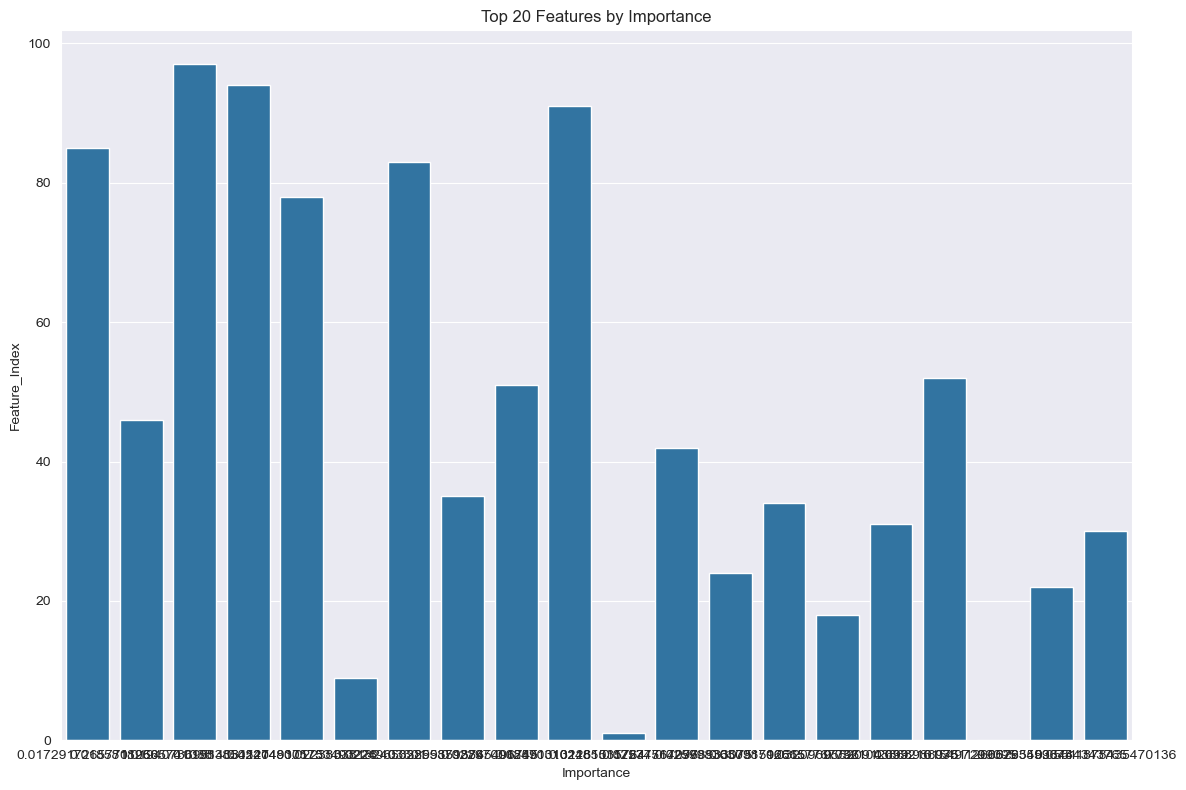

In [9]:
with mlflow.start_run(run_name=f"{model_name}_Feature_Analysis") as run:
    try:
        rf_model = final_pipeline.named_steps['classifier']
        
        if hasattr(rf_model, 'feature_importances_'):
            importances = rf_model.feature_importances_
            
            try:
                feature_indices = range(len(importances))
                
                importance_df = pd.DataFrame({
                    'Feature_Index': feature_indices,
                    'Importance': importances
                }).sort_values('Importance', ascending=False)
                
                plt.figure(figsize=(12, 8))
                sns.barplot(x='Importance', y='Feature_Index', data=importance_df.head(20))
                plt.title('Top 20 Features by Importance')
                plt.tight_layout()
                
                importance_plot = "rf_feature_importance.png"
                plt.savefig(importance_plot)
                mlflow.log_artifact(importance_plot)
                
                mlflow.log_param("top_feature_indices", importance_df['Feature_Index'].head(20).tolist())
                mlflow.log_param("top_feature_importances", importance_df['Importance'].head(20).tolist())
                
                print("Feature importance analysis complete.")
            except Exception as e:
                print(f"Error extracting feature names: {e}")
        else:
            print("Model does not have feature_importances_ attribute.")
            mlflow.log_param("feature_importance_analysis", "model_has_no_importances")
    except Exception as e:
        print(f"Feature importance analysis failed: {e}")
        mlflow.log_param("feature_importance_analysis", "failed")